## 범주형 데이터 이진분류

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import datetime
import missingno as msno
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

# Options for pandas
pd.options.display.max_columns = 150

### 데이터 둘러보기

In [2]:
data_path = 'data/cat-in-the-dat/'

train = pd.read_csv(data_path + 'train.csv', index_col='id')
test = pd.read_csv(data_path + 'test.csv', index_col='id')

submission = pd.read_csv(data_path + 'sample_submission.csv', index_col='id')

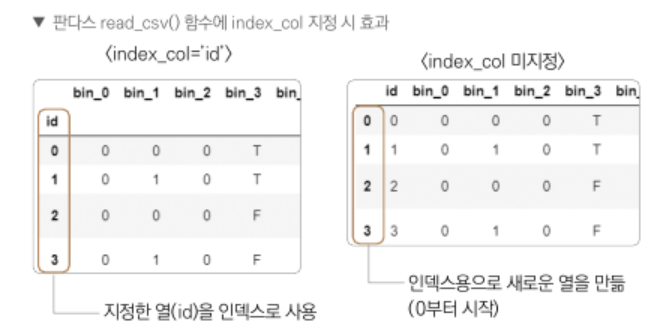

In [3]:
print(train.shape)
print(test.shape)

(300000, 24)
(200000, 23)


In [4]:
train.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
id,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,50f116bcf,3ac1b8814,68f6ad3e9,c389000ab,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,b3b4d25d0,fbcb50fc1,3b6dd5612,4cd920251,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,3263bdce5,0922e3cb8,a6a36f527,de9c9f684,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0
3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,f12246592,50d7ad46a,ec69236eb,4ade6ab69,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1
4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,5b0f5acd5,1fe17a1fd,04ddac2be,cb43ab175,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0


열이 여러개인 데이터는 T 메서드를 사용하면 유용하다.

In [5]:
train.head().T

id,0,1,2,3,4
bin_0,0,0,0,0,0
bin_1,0,1,0,1,0
bin_2,0,0,0,0,0
bin_3,T,T,F,F,F
bin_4,Y,Y,Y,Y,N
nom_0,Green,Green,Blue,Red,Red
nom_1,Triangle,Trapezoid,Trapezoid,Trapezoid,Trapezoid
nom_2,Snake,Hamster,Lion,Snake,Lion
nom_3,Finland,Russia,Russia,Canada,Canada
nom_4,Bassoon,Piano,Theremin,Oboe,Oboe


In [6]:
submission.head()

,target
id,
300000,0.5
300001,0.5
300002,0.5
300003,0.5
300004,0.5


피처 요약표 만들기

In [7]:
def resumetable(df):
    print(f'데이터 셋 형상: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index': '피처'})
    summary['결측값 개수'] = df.isnull().sum().values
    summary['고윳값 개수'] = df.nunique().values
    summary['첫 번째 값'] = df.loc[0].values
    summary['두 번째 값'] = df.loc[1].values
    summary['세 번째 값'] = df.loc[2].values
    
    return summary

In [8]:
resumetable(train)

데이터 셋 형상: (300000, 24)


,피처,데이터 타입,결측값 개수,고윳값 개수,첫 번째 값,두 번째 값,세 번째 값
0,bin_0,int64,0,2,0,0,0
1,bin_1,int64,0,2,0,1,0
2,bin_2,int64,0,2,0,0,0
3,bin_3,object,0,2,T,T,F
4,bin_4,object,0,2,Y,Y,Y
5,nom_0,object,0,3,Green,Green,Blue
6,nom_1,object,0,6,Triangle,Trapezoid,Trapezoid
7,nom_2,object,0,6,Snake,Hamster,Lion
8,nom_3,object,0,6,Finland,Russia,Russia
9,nom_4,object,0,4,Bassoon,Piano,Theremin


피처 요약표 해석하기

In [9]:
for i in range(3):
    feature = 'ord_' +str(i)
    print(f'{feature} 고유값 : {train[feature].unique()}')

ord_0 고유값 : [2 1 3]
ord_1 고유값 : ['Grandmaster' 'Expert' 'Novice' 'Contributor' 'Master']
ord_2 고유값 : ['Cold' 'Hot' 'Lava Hot' 'Boiling Hot' 'Freezing' 'Warm']


In [10]:
for i in range(3, 6):
    feature = 'ord_' + str(i)
    print(f'{feature} 고윳값: {train[feature].unique()}')

ord_3 고윳값: ['h' 'a' 'i' 'j' 'g' 'e' 'd' 'b' 'k' 'f' 'l' 'n' 'o' 'c' 'm']
ord_4 고윳값: ['D' 'A' 'R' 'E' 'P' 'K' 'V' 'Q' 'Z' 'L' 'F' 'T' 'U' 'S' 'Y' 'B' 'H' 'J'
 'N' 'G' 'W' 'I' 'O' 'C' 'X' 'M']
ord_5 고윳값: ['kr' 'bF' 'Jc' 'kW' 'qP' 'PZ' 'wy' 'Ed' 'qo' 'CZ' 'qX' 'su' 'dP' 'aP'
 'MV' 'oC' 'RL' 'fh' 'gJ' 'Hj' 'TR' 'CL' 'Sc' 'eQ' 'kC' 'qK' 'dh' 'gM'
 'Jf' 'fO' 'Eg' 'KZ' 'Vx' 'Fo' 'sV' 'eb' 'YC' 'RG' 'Ye' 'qA' 'lL' 'Qh'
 'Bd' 'be' 'hT' 'lF' 'nX' 'kK' 'av' 'uS' 'Jt' 'PA' 'Er' 'Qb' 'od' 'ut'
 'Dx' 'Xi' 'on' 'Dc' 'sD' 'rZ' 'Uu' 'sn' 'yc' 'Gb' 'Kq' 'dQ' 'hp' 'kL'
 'je' 'CU' 'Fd' 'PQ' 'Bn' 'ex' 'hh' 'ac' 'rp' 'dE' 'oG' 'oK' 'cp' 'mm'
 'vK' 'ek' 'dO' 'XI' 'CM' 'Vf' 'aO' 'qv' 'jp' 'Zq' 'Qo' 'DN' 'TZ' 'ke'
 'cG' 'tP' 'ud' 'tv' 'aM' 'xy' 'lx' 'To' 'uy' 'ZS' 'vy' 'ZR' 'AP' 'GJ'
 'Wv' 'ri' 'qw' 'Xh' 'FI' 'nh' 'KR' 'dB' 'BE' 'Bb' 'mc' 'MC' 'tM' 'NV'
 'ih' 'IK' 'Ob' 'RP' 'dN' 'us' 'dZ' 'yN' 'Nf' 'QM' 'jV' 'sY' 'wu' 'SB'
 'UO' 'Mx' 'JX' 'Ry' 'Uk' 'uJ' 'LE' 'ps' 'kE' 'MO' 'kw' 'yY' 'zU' 'bJ'
 'Kf' 'ck' 'mb' '

In [11]:
print('day 고윳값:', train['day'].unique())
print('month 고윳값:', train['month'].unique())
print('target 고윳값:', train['target'].unique())

day 고윳값: [2 7 5 4 3 1 6]
month 고윳값: [ 2  8  1  4 10  3  7  9 12 11  5  6]
target 고윳값: [0 1]


타겟 분포

[Text(0.5, 1.0, 'Target Distribution')]

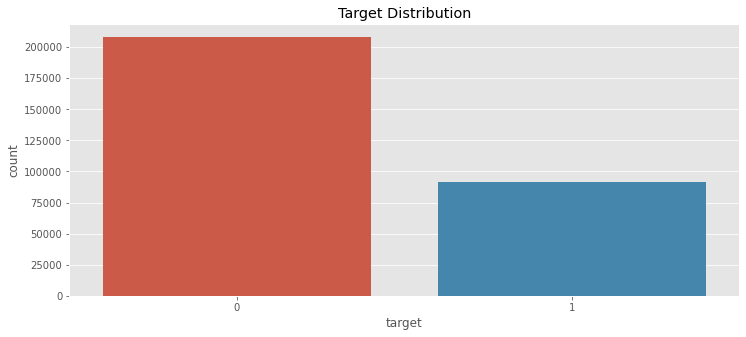

In [12]:
plt.figure(figsize = (12, 5))

ax = sns.countplot(x = 'target', data= train)
ax.set(title= 'Target Distribution')

<AxesSubplot:>

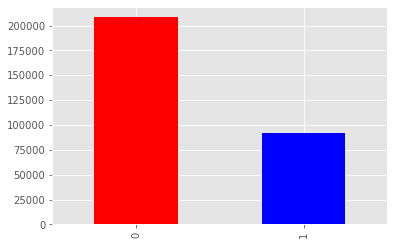

In [13]:
train['target'].value_counts().plot(kind = 'bar', color = ['r', 'b'])

- 그래프에 갃 값의 비율을 표시하려면 글자 위치를 알아야 함

ax.patches : ax 축을 구성하는 그래프 도형 객체 모두를 담은 리스트

In [14]:
print(ax.patches)

<Axes.ArtistList of 2 patches>


- 두개의 객체를 포함하는 리스트이다.   


첫번째 Rectangle 객체의 위치를 찾아보자.

In [15]:
rectangle = ax.patches[0]
print('사각형 높이:', rectangle.get_height())
print('사각형 너비:', rectangle.get_width())
print('사각형 왼쪽 테두리의 x축 위치:', rectangle.get_x())

사각형 높이: 208236
사각형 너비: 0.8
사각형 왼쪽 테두리의 x축 위치: -0.4


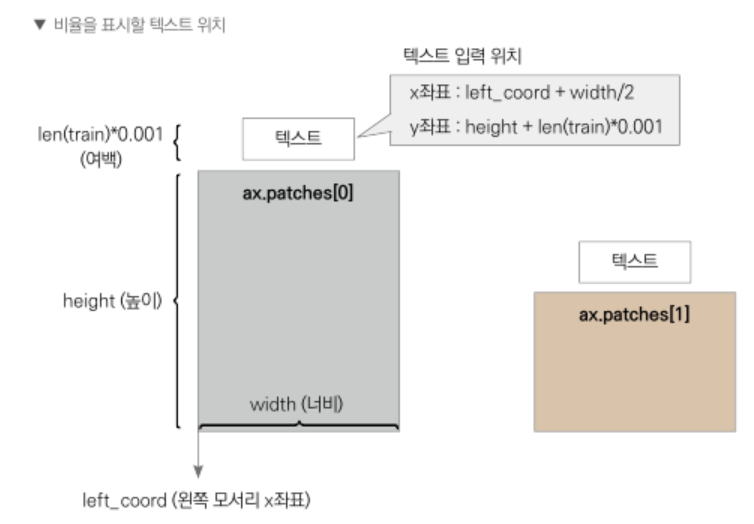

- 참고로 countplot()에서 도형의 높이는 데이터의 개수와 같다.

In [16]:
print('텍스트 위치의 x좌표:', rectangle.get_x() + rectangle.get_width()/2.0)
print('텍스트 위치의 y좌표:', rectangle.get_height() + len(train)*0.001)

텍스트 위치의 x좌표: 0.0
텍스트 위치의 y좌표: 208536.0


타깃 값을 표시하도록 하는 함수 만들기

In [17]:
def write_percent(ax, total_size):
    for patch in ax.patches:
        height = patch.get_height()
        width = patch.get_width()
        left_cord = patch.get_x()
        percent = height/ total_size*100
        
        ax.text(x = left_cord + width/2.0,
               y = height + total_size*0.001,
               s = f'{percent: 1.1f}%', 
               ha = 'center')

Text(0.5, 1.0, 'Target Distribution')

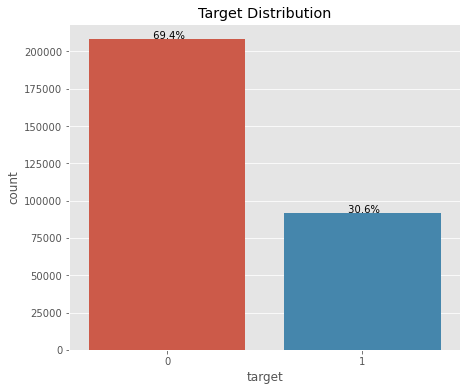

In [18]:
plt.figure(figsize = (7, 6))
ax = sns.countplot(x='target', data = train)
write_percent(ax, len(train))
ax.set_title('Target Distribution')

이진 피처 분포

In [19]:
import matplotlib.gridspec as gridspec

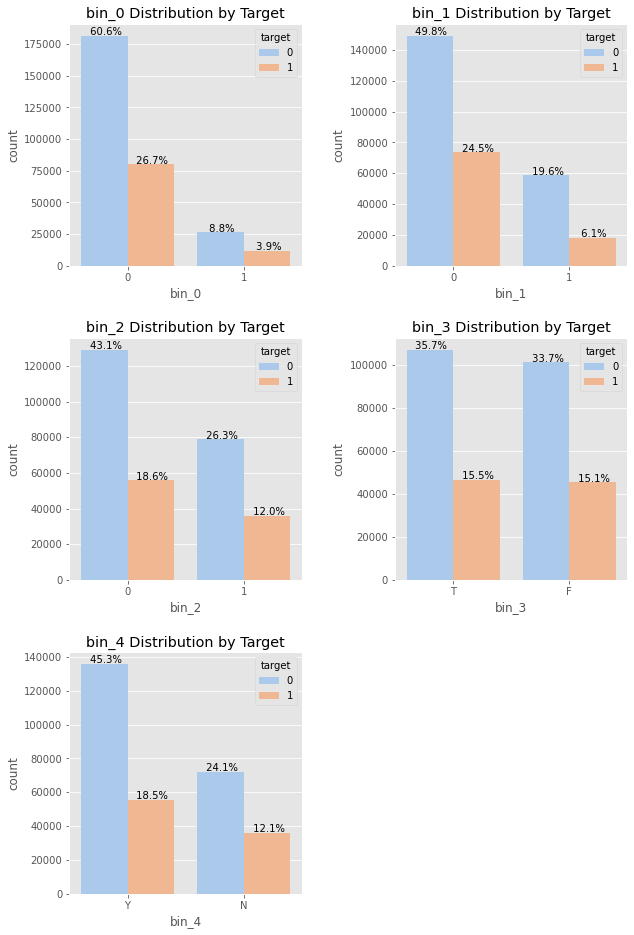

In [20]:
# 3행 2열 틀(Figure) 준비
mpl.rc('font', size=10)
grid = gridspec.GridSpec(3, 2) # 그래프(서브플롯)를 3행 2열로 배치
plt.figure(figsize=(10, 16))   # 전체 Figure 크기 설정
plt.subplots_adjust(wspace=0.4, hspace=0.3) # 서브플롯 간 좌우/상하 여백 설정

bin_features = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4']

for idx, feature in enumerate(bin_features):
    ax = plt.subplot(grid[idx])
    
    sns.countplot(x=feature, data=train,
                 hue= 'target', palette='pastel',
                  ax = ax)
    
    ax.set_title(f'{feature} Distribution by Target')
    write_percent(ax, len(train))

명목형(norminal) 피처 분포  


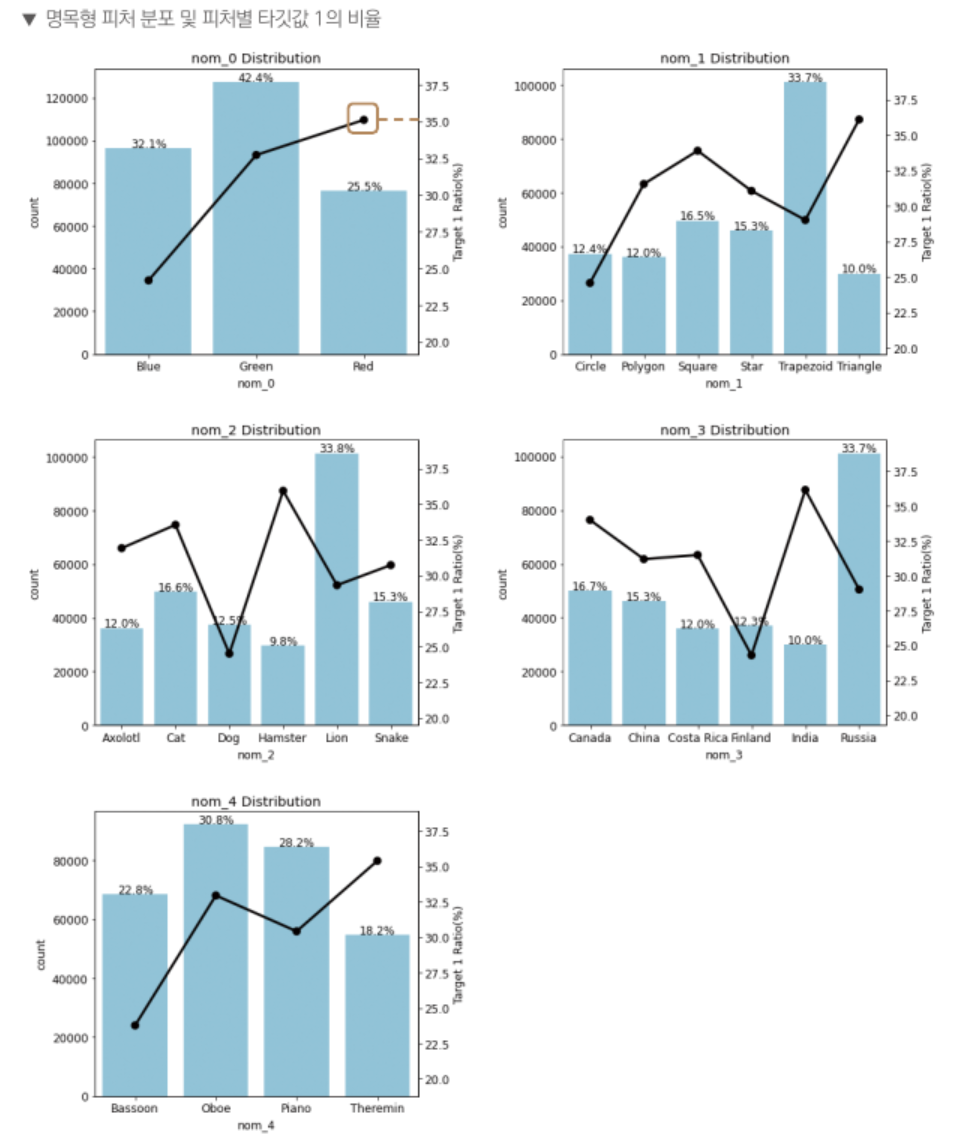

- 전번째 그림에서 norm_0 피처의 고유값(유니크한 값)은 Blue, Green, Red이며 각각 32.1, 42.4, 25.5 퍼센트를 차지한다.  
- 꺾은선 그래프는 각 고유 값중에 타겟 1의 비중을 나타낸다.   
- 각 고윳값 별로 타겟의 비가 다르므로 모델링에 사용할 가치가 있다.

위 차트를 그리는 절차는 다음과 같다.  
1. 교차분석표 생성 함수 만들기  
2. 포인트플롯 생성 함수 만들기  
3. 피처 분포도 및 포인트플롯 생성 함수 만들기  

스텝1. 교차분석표 생성 함수 만들기

교차표(cross-tabulation), 또는 교차 분석표 : 범주형 데이터 2개를 분석하는데 사용하는 표.  

각 범주형 데이터의 빈도나 통계량을 행과 열로 결합해 놓은 표.   
교차 분석표를 만드는 이유는 명목형 피처별 타깃 값 1을 구하기 위해서 임

In [21]:
pd.crosstab(train['nom_0'], train['target'])

target,0,1
nom_0,,
Blue,72914,23252
Green,85682,41659
Red,49640,26853


인덱스(row)를 기준으로 정규화 하기

In [22]:
crosstab = pd.crosstab(train['nom_0'], train['target'], normalize='index')*100

In [23]:
crosstab

target,0,1
nom_0,,
Blue,75.820976,24.179024
Green,67.285478,32.714522
Red,64.894827,35.105173


In [24]:
crosstab = crosstab.reset_index()
crosstab

target,nom_0,0,1
0,Blue,75.820976,24.179024
1,Green,67.285478,32.714522
2,Red,64.894827,35.105173


함수로 만들기

In [25]:
def get_crosstab(df, feature):
    crosstab = pd.crosstab(df[feature], df['target'], normalize='index')*100
    crosstab = crosstab.reset_index()
    return crosstab

In [26]:
crosstab = get_crosstab(train, 'nom_0')
crosstab

target,nom_0,0,1
0,Blue,75.820976,24.179024
1,Green,67.285478,32.714522
2,Red,64.894827,35.105173


타겟 1에 대한 비율을 확인하고 싶다면

In [27]:
crosstab[1]

0    24.179024
1    32.714522
2    35.105173
Name: 1, dtype: float64

스텝2 : 포인트 플롯 생성 함수 만들기  
카운트 플롯 위에 그릴 포인트플롯 그림그리는 함수 만들기

In [28]:
def plot_pointplot(ax, feature, crosstab):
    ax2 = ax.twinx() # x축은 공유하고 y축은 공유하지 않는 새로운 축 생성
    # 새로운 축에 포인트플롯 그리기
    ax2 = sns.pointplot(x=feature, y=1, data=crosstab,
                        order=crosstab[feature].values, # 포인트플롯 순서
                        color='black',                  # 포인트플롯 색상
                        legend=False)                   # 범례 미표시
    ax2.set_ylim(crosstab[1].min()-5, crosstab[1].max()*1.1) # y축 범위 설정
    ax2.set_ylabel('Target 1 Ratio(%)')

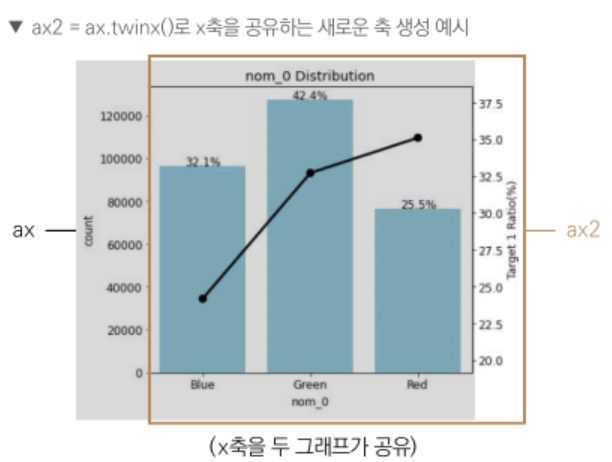

스텝3: 피처 분포도 및 피처별 타깃 값 1의 비율 포인트 플롯 생성함수 만들기

In [29]:
def plot_cat_dist_with_true_ratio(df, features, num_rows, num_cols, size = (15, 20)):
    
    plt.figure(figsize=size)
    grid = gridspec.GridSpec(num_rows, num_cols)
    plt.subplots_adjust(wspace=0.45, hspace=0.3) # 서브플롯 좌우/상하 여백 설정
    
    for idx, feature in enumerate(features):
        ax = plt.subplot(grid[idx])
        crosstab = get_crosstab(df, feature) # 교차 분석표 생성
        
        sns.countplot(x= feature, data=df, order=crosstab[feature].values,
                     color='skyblue', ax = ax)
        
        write_percent(ax, len(df)) # 비율 표시
       
        plot_pointplot(ax, feature, crosstab) # 포인트플롯 그리기
        
        ax.set_title(f'{feature} Distribution')

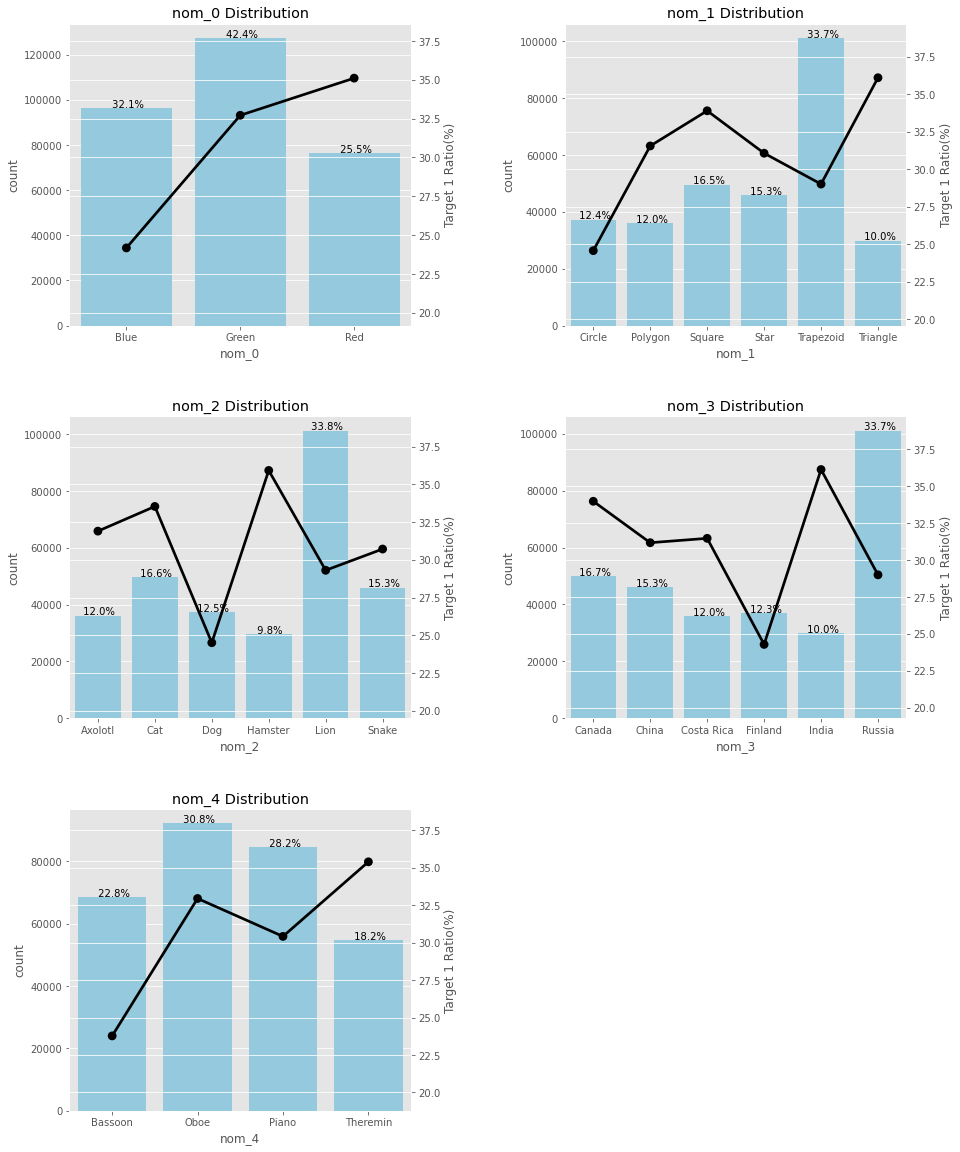

In [30]:
nom_features = ['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4'] # 명목형 피처
plot_cat_dist_with_true_ratio(train, nom_features, num_rows=3, num_cols=2)

순서형(ordinal) 피처 분포

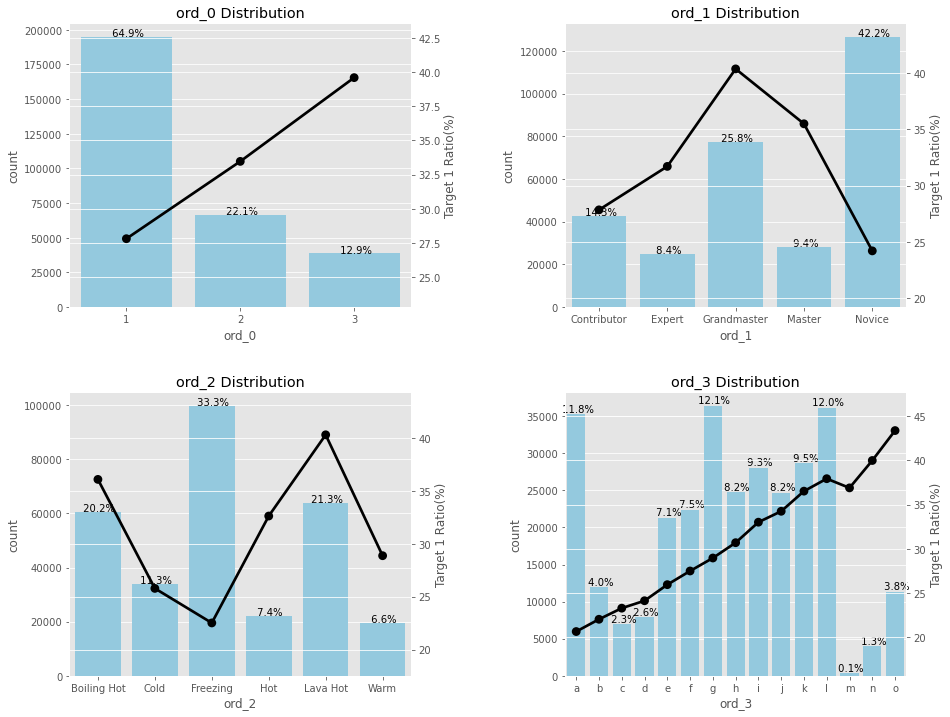

In [31]:
ord_features = ['ord_0', 'ord_1', 'ord_2', 'ord_3'] # 순서형 피처
plot_cat_dist_with_true_ratio(train, ord_features, 
                              num_rows=2, num_cols=2, size=(15, 12))

- ord1,2 피처는 순서가 정렬되지 않았다.  
- 따라서 다음과 같이 정렬한다.  

ord_1_value = ['Novice', 'Contributor', 'Expert', 'Master', 'Grandmaster']  
ord_2_value = ['Freezing', 'Cold', 'Warm', 'Hot', 'Boiling Hot', 'Lava Hot']

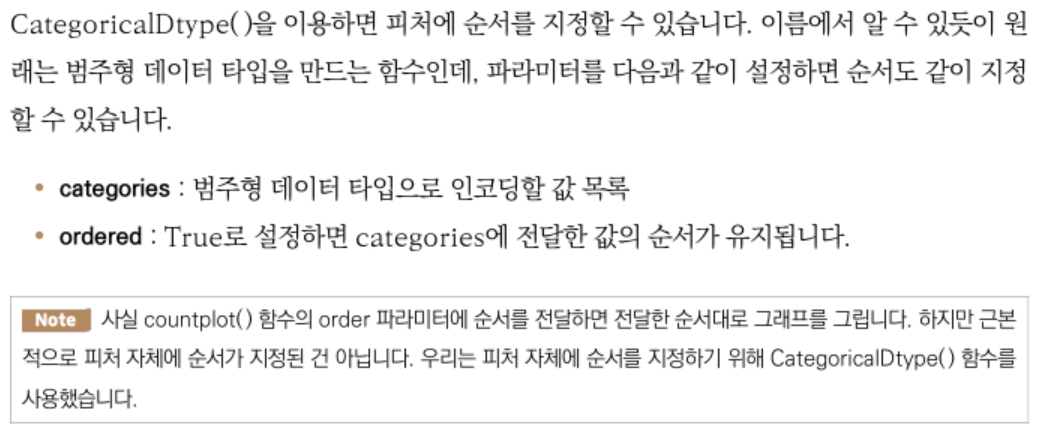

이제 CategoriclaDtype을 적용해 ord1과 2 피처에 순서를 지정해본다.

In [32]:
from pandas.api.types import CategoricalDtype 

In [33]:
ord_1_value = ['Novice', 'Contributor', 'Expert', 'Master', 'Grandmaster']
ord_2_value = ['Freezing', 'Cold', 'Warm', 'Hot', 'Boiling Hot', 'Lava Hot']

# 순서를 지정한 범주형 데이터 타입
ord_1_dtype = CategoricalDtype(categories=ord_1_value, ordered=True)
ord_2_dtype = CategoricalDtype(categories=ord_2_value, ordered=True)

In [34]:
ord_1_dtype

CategoricalDtype(categories=['Novice', 'Contributor', 'Expert', 'Master', 'Grandmaster'], ordered=True)

In [35]:
# 데이터 타입 변경
train['ord_1'] = train['ord_1'].astype(ord_1_dtype)
train['ord_2'] = train['ord_2'].astype(ord_2_dtype)

In [36]:
train['ord_1']

id
0         Grandmaster
1         Grandmaster
2              Expert
3         Grandmaster
4         Grandmaster
             ...     
299995    Contributor
299996         Novice
299997         Novice
299998         Master
299999    Contributor
Name: ord_1, Length: 300000, dtype: category
Categories (5, object): ['Novice' < 'Contributor' < 'Expert' < 'Master' < 'Grandmaster']

다시 그려보자

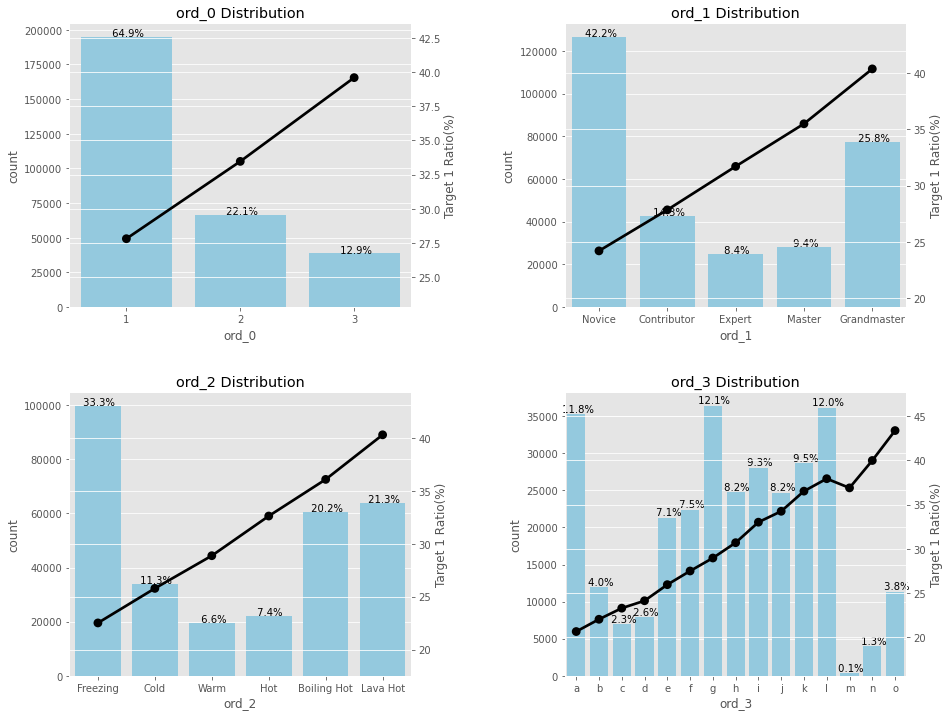

In [37]:
plot_cat_dist_with_true_ratio(train, ord_features, 
                              num_rows=2, num_cols=2, size=(15, 12))

다음으로 ord_4, 5의 분포를 살펴보자.   
고윳 값의 개수가 많기 때문에 가로 길이를 늘려서 그림

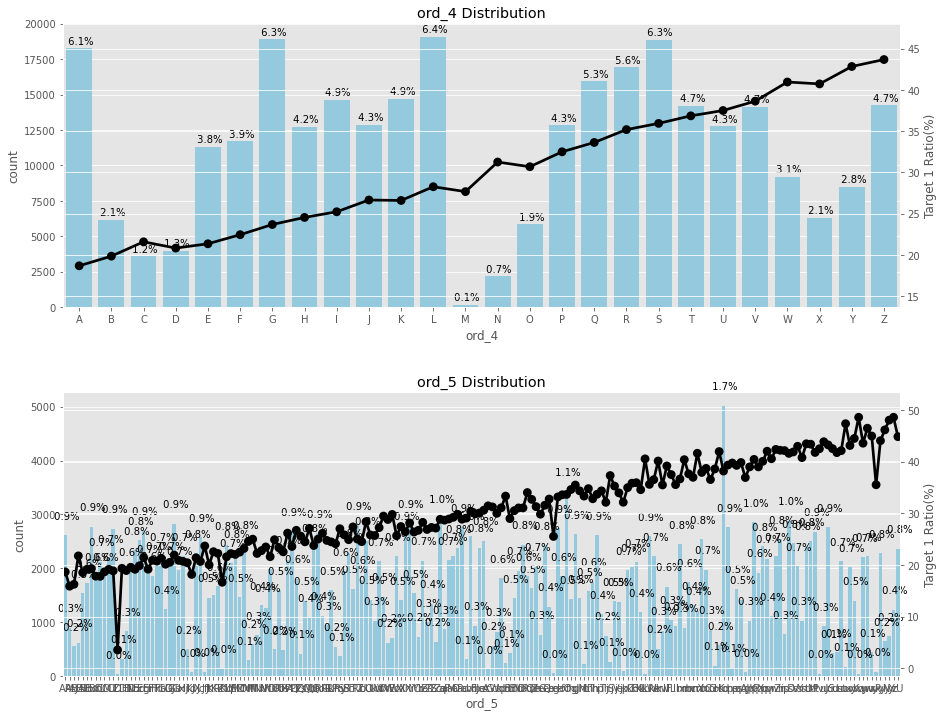

In [38]:
plot_cat_dist_with_true_ratio(train, ['ord_4', 'ord_5'], 
                              num_rows=2, num_cols=1, size=(15, 12))

- 고윳 값 순서에 따라 타겟 1의 비율이 증가하는 것을 알 수가 있다.

날짜 피처 분포

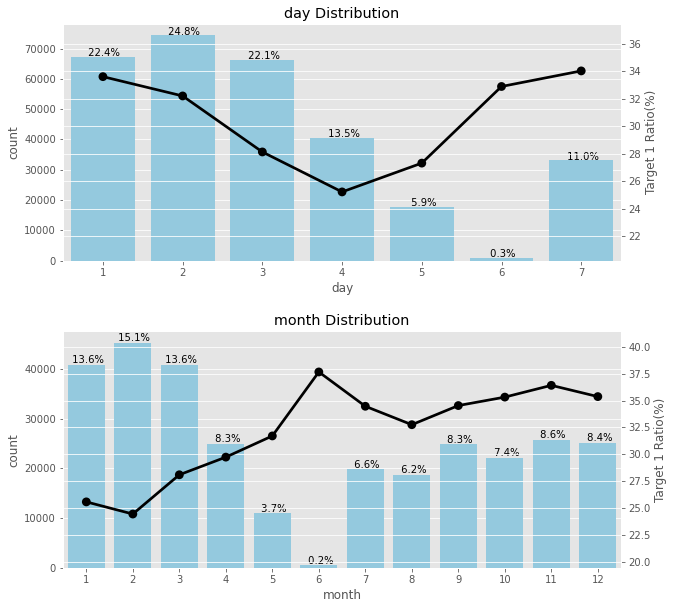

In [39]:
date_features = ['day', 'month']
plot_cat_dist_with_true_ratio(train, date_features, 
                              num_rows=2, num_cols=1, size=(10, 10))

- day 기준으로 중간 요일에 1의 비중이 줄어든다.  
- month의 경우 day와 반대 양상을 보인다.

- 그런데 12와 1의 차이는 한달 차이이지만, 머신러닝은 11의 차이로 본다....

- 이럴 때 삼각함수를 사용하면 매끄럽게 문제가 해결된다.   
- 매년, 매월, 매주, 매일 반복되는 데이터를 순환형(cyclical data)라고 부른다.  

- 하지만 경진대회에서 요일, 월 피처에 원핫인코딩을 적용하는 것이 오히려 성능이 좋았다.  
- 따라서 월, 요일에도 명목형 피처를 인코딩 할때와 마찬가지로 원-핫 인코딩을 적용

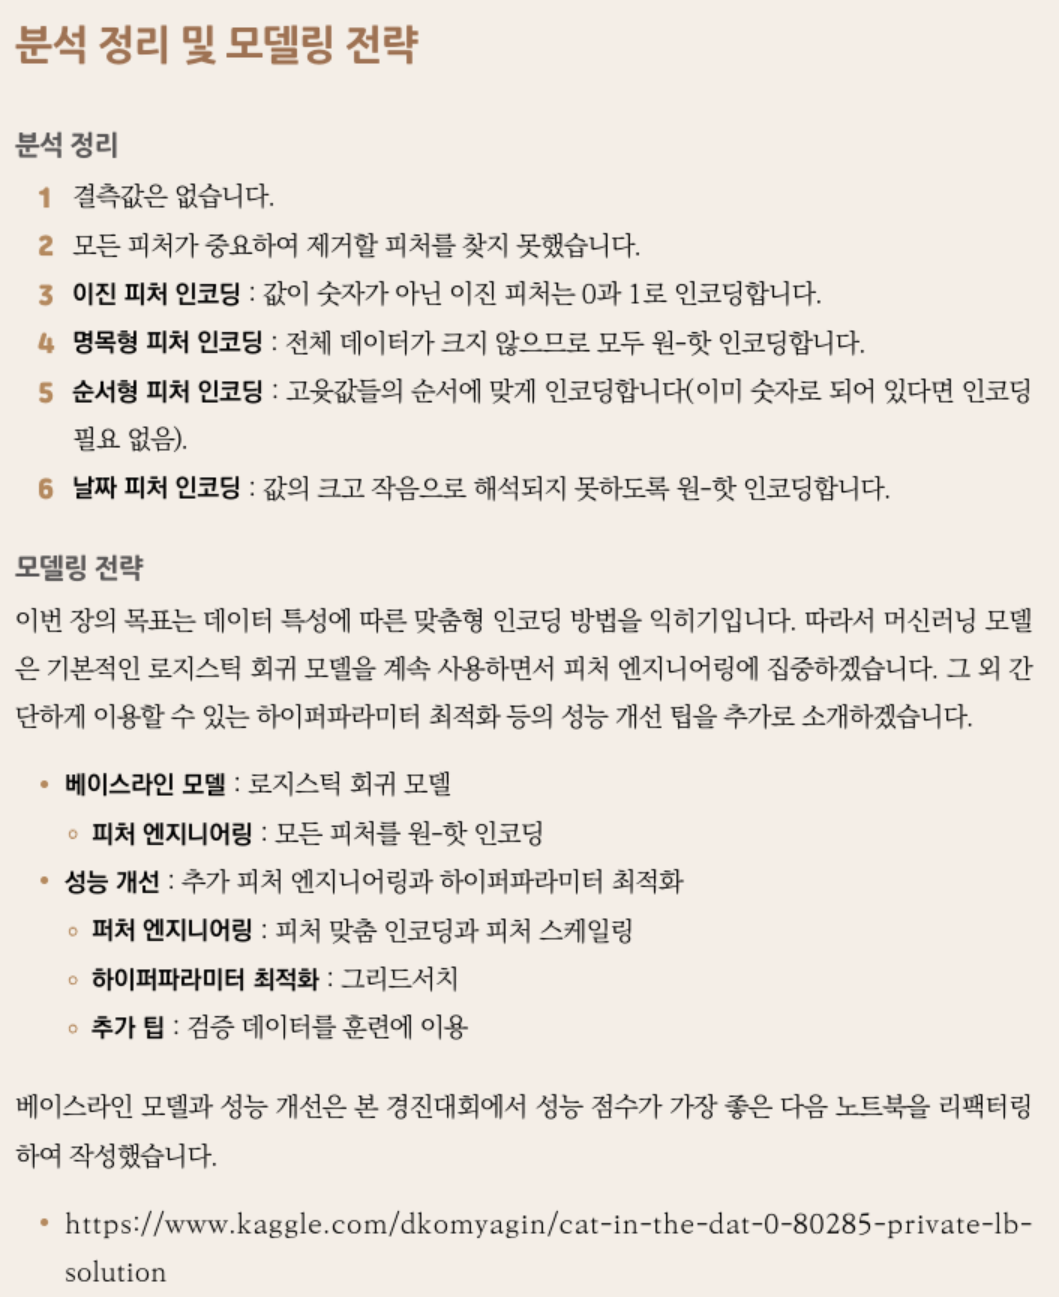

### 7.3 베이스라인 모델

In [44]:
all_data = pd.concat([train, test])
all_data = all_data.drop('target', axis = 1)
all_data

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
id,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,50f116bcf,3ac1b8814,68f6ad3e9,c389000ab,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2
1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,b3b4d25d0,fbcb50fc1,3b6dd5612,4cd920251,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8
2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,3263bdce5,0922e3cb8,a6a36f527,de9c9f684,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2
3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,f12246592,50d7ad46a,ec69236eb,4ade6ab69,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1
4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,5b0f5acd5,1fe17a1fd,04ddac2be,cb43ab175,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,0,0,0,F,N,Green,Square,Lion,Canada,Theremin,6c90f81cd,a406a5f12,d02a6b0ba,9e4b23160,acc31291f,1,Novice,Lava Hot,j,A,Gb,1,3
499996,1,0,0,F,Y,Green,Trapezoid,Lion,China,Piano,2d61990e2,520806ce2,d2d8eabdb,cfbd87ed0,eae3446d0,1,Contributor,Lava Hot,f,S,Ed,2,2
499997,0,1,1,T,Y,Green,Trapezoid,Lion,Canada,Oboe,488406659,28645754b,22831fffe,1108bcd6c,33dd3cf4b,1,Novice,Boiling Hot,g,V,TR,3,1


In [45]:
from sklearn.preprocessing import OneHotEncoder

In [46]:
encoder = OneHotEncoder()
all_data_encoded = encoder.fit_transform(all_data)

In [50]:
all_data_encoded

<500000x16552 sparse matrix of type '<class 'numpy.float64'>'
	with 11500000 stored elements in Compressed Sparse Row format>

데이터 나누기

In [51]:
num_train = len(train)

X_train = all_data_encoded[:num_train]
X_test = all_data_encoded[num_train:]

y = train['target']

In [52]:
from sklearn.model_selection import train_test_split

# 훈련 데이터, 검증 데이터 분리
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y,
                                                      test_size=0.1,
                                                      stratify=y,
                                                      random_state=10)

모델 훈련

In [53]:
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

모델 성능 검증   
predict_proba 메서드를 사용하면 0, 1일 확률이 출력된다.

In [55]:
logistic_model.predict_proba(X_valid)

array([[0.23276567, 0.76723433],
       [0.91412175, 0.08587825],
       [0.83043558, 0.16956442],
       ...,
       [0.24845673, 0.75154327],
       [0.4946481 , 0.5053519 ],
       [0.95659148, 0.04340852]])

In [56]:
logistic_model.predict(X_valid)

array([1, 0, 0, ..., 1, 1, 0], dtype=int64)

여기서는 1일 확률을 예측해야한다.  
따라서 predict_proba 메서드로 두번쨰 컬럼의 예측 값을 사용한다.

In [57]:
y_valid_preds = logistic_model.predict_proba(X_valid)[:, 1]

In [58]:
y_valid_preds

array([0.76723433, 0.08587825, 0.16956442, ..., 0.75154327, 0.5053519 ,
       0.04340852])

In [59]:
from sklearn.metrics import roc_auc_score

In [61]:
roc_auc = roc_auc_score(y_valid, y_valid_preds)

In [62]:
roc_auc

0.7965036078098472

예측 및 결과 제출

In [63]:
y_preds = logistic_model.predict_proba(X_test)[:, 1]

In [64]:
submission.head()

,target
id,
300000,0.5
300001,0.5
300002,0.5
300003,0.5
300004,0.5


In [65]:
submission['target'] = y_preds
submission.to_csv('data/cat-in-the-dat/submission.csv')

### 성능 개선

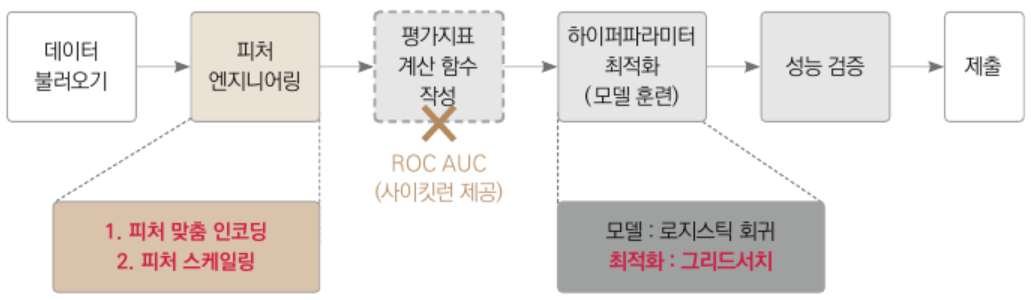

피처 맞춤 인코딩

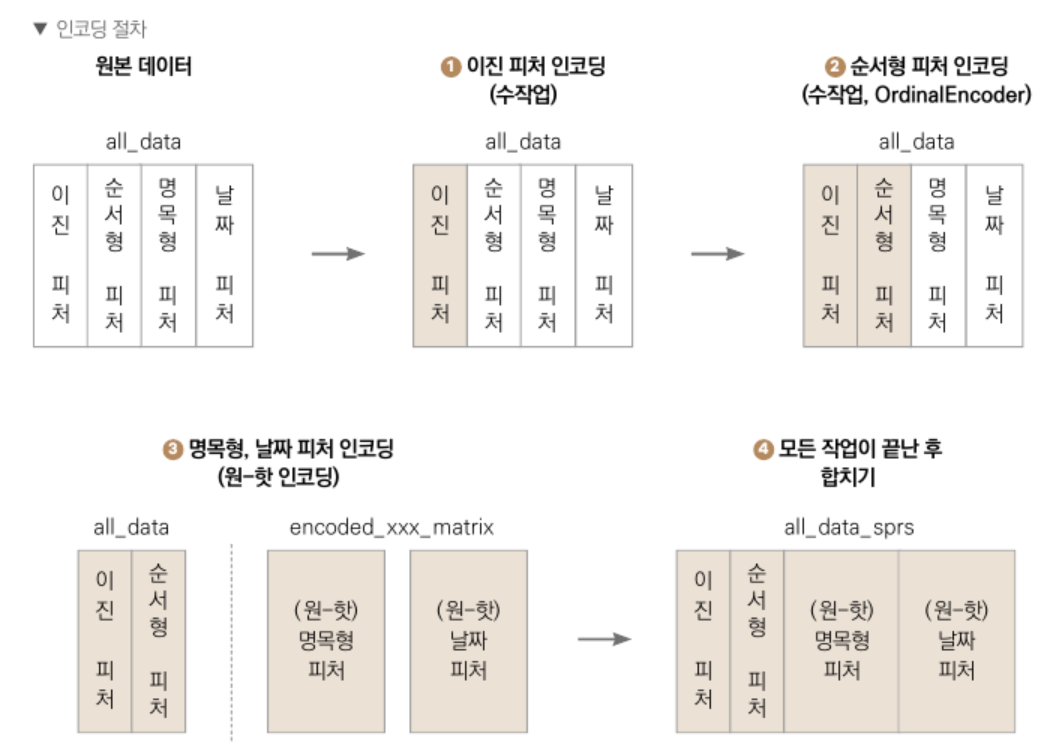

In [94]:
data_path = 'data/cat-in-the-dat/'

train = pd.read_csv(data_path + 'train.csv', index_col='id')
test = pd.read_csv(data_path + 'test.csv', index_col='id')

submission = pd.read_csv(data_path + 'sample_submission.csv', index_col='id')

In [95]:
# 훈련 데이터와 테스트 데이터 합치기
all_data = pd.concat([train, test])
all_data = all_data.drop('target', axis=1) # 타깃값 제거

이진 피처 인코딩

In [96]:
all_data['bin_3'] = all_data['bin_3'].map({'F':0, 'T':1})
all_data['bin_4'] = all_data['bin_4'].map({'F':0, 'T':1})

순서형 피처 인코딩

In [97]:
ord1dict = {'Novice':0, 'Contributor':1, 
            'Expert':2, 'Master':3, 'Grandmaster':4}
ord2dict = {'Freezing':0, 'Cold':1, 'Warm':2, 
            'Hot':3, 'Boiling Hot':4, 'Lava Hot':5}

all_data['ord_1'] = all_data['ord_1'].map(ord1dict)
all_data['ord_2'] = all_data['ord_2'].map(ord2dict)

In [98]:
from sklearn.preprocessing import OrdinalEncoder

In [99]:
ord_345 = ['ord_3', 'ord_4', 'ord_5']

ord_encoder = OrdinalEncoder() # OrdinalEncoder 객체 생성
# ordinal 인코딩 적용
all_data[ord_345] = ord_encoder.fit_transform(all_data[ord_345])

In [100]:
ord_encoder.categories_

[array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
        'n', 'o'], dtype=object),
 array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
        'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'],
       dtype=object),
 array(['AP', 'Ai', 'Aj', 'BA', 'BE', 'Bb', 'Bd', 'Bn', 'CL', 'CM', 'CU',
        'CZ', 'Cl', 'DH', 'DN', 'Dc', 'Dx', 'Ed', 'Eg', 'Er', 'FI', 'Fd',
        'Fo', 'GD', 'GJ', 'Gb', 'Gx', 'Hj', 'IK', 'Id', 'JX', 'Jc', 'Jf',
        'Jt', 'KR', 'KZ', 'Kf', 'Kq', 'LE', 'MC', 'MO', 'MV', 'Mf', 'Ml',
        'Mx', 'NV', 'Nf', 'Nk', 'OR', 'Ob', 'Os', 'PA', 'PQ', 'PZ', 'Ps',
        'QM', 'Qb', 'Qh', 'Qo', 'RG', 'RL', 'RP', 'Rm', 'Ry', 'SB', 'Sc',
        'TR', 'TZ', 'To', 'UO', 'Uk', 'Uu', 'Vf', 'Vx', 'WE', 'Wc', 'Wv',
        'XI', 'Xh', 'Xi', 'YC', 'Yb', 'Ye', 'ZR', 'ZS', 'Zc', 'Zq', 'aF',
        'aM', 'aO', 'aP', 'ac', 'av', 'bF', 'bJ', 'be', 'cA', 'cG', 'cW',
        'ck', 'cp', 'dB', 'dE', 'dN', 'dO', 'dP', 'dQ', 'd

In [101]:
for feature, categories in zip(ord_345, ord_encoder.categories_):
    print(feature)
    print(categories)

ord_3
['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o']
ord_4
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']
ord_5
['AP' 'Ai' 'Aj' 'BA' 'BE' 'Bb' 'Bd' 'Bn' 'CL' 'CM' 'CU' 'CZ' 'Cl' 'DH'
 'DN' 'Dc' 'Dx' 'Ed' 'Eg' 'Er' 'FI' 'Fd' 'Fo' 'GD' 'GJ' 'Gb' 'Gx' 'Hj'
 'IK' 'Id' 'JX' 'Jc' 'Jf' 'Jt' 'KR' 'KZ' 'Kf' 'Kq' 'LE' 'MC' 'MO' 'MV'
 'Mf' 'Ml' 'Mx' 'NV' 'Nf' 'Nk' 'OR' 'Ob' 'Os' 'PA' 'PQ' 'PZ' 'Ps' 'QM'
 'Qb' 'Qh' 'Qo' 'RG' 'RL' 'RP' 'Rm' 'Ry' 'SB' 'Sc' 'TR' 'TZ' 'To' 'UO'
 'Uk' 'Uu' 'Vf' 'Vx' 'WE' 'Wc' 'Wv' 'XI' 'Xh' 'Xi' 'YC' 'Yb' 'Ye' 'ZR'
 'ZS' 'Zc' 'Zq' 'aF' 'aM' 'aO' 'aP' 'ac' 'av' 'bF' 'bJ' 'be' 'cA' 'cG'
 'cW' 'ck' 'cp' 'dB' 'dE' 'dN' 'dO' 'dP' 'dQ' 'dZ' 'dh' 'eG' 'eQ' 'eb'
 'eg' 'ek' 'ex' 'fO' 'fh' 'gJ' 'gM' 'hL' 'hT' 'hh' 'hp' 'iT' 'ih' 'jS'
 'jV' 'je' 'jp' 'kC' 'kE' 'kK' 'kL' 'kU' 'kW' 'ke' 'kr' 'kw' 'lF' 'lL'
 'll' 'lx' 'mb' 'mc' 'mm' 'nX' 'nh' 'oC' 'oG' 'oH' 'oK' 'od' 'on' 'pa'
 'ps' 'qA' 'qJ' 'qK' 'qP' 'qX' '

명목형 피처 인코딩

In [102]:
train.columns

Index(['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2',
       'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_0',
       'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month', 'target'],
      dtype='object')

In [103]:
nom_features = ['nom_' + str(i) for i in range(10)]

In [104]:
nom_features

['nom_0',
 'nom_1',
 'nom_2',
 'nom_3',
 'nom_4',
 'nom_5',
 'nom_6',
 'nom_7',
 'nom_8',
 'nom_9']

In [105]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder() # OneHotEncoder 객체 생성
# 원-핫 인코딩 적용
encoded_nom_matrix = onehot_encoder.fit_transform(all_data[nom_features])

encoded_nom_matrix

<500000x16276 sparse matrix of type '<class 'numpy.float64'>'
	with 5000000 stored elements in Compressed Sparse Row format>

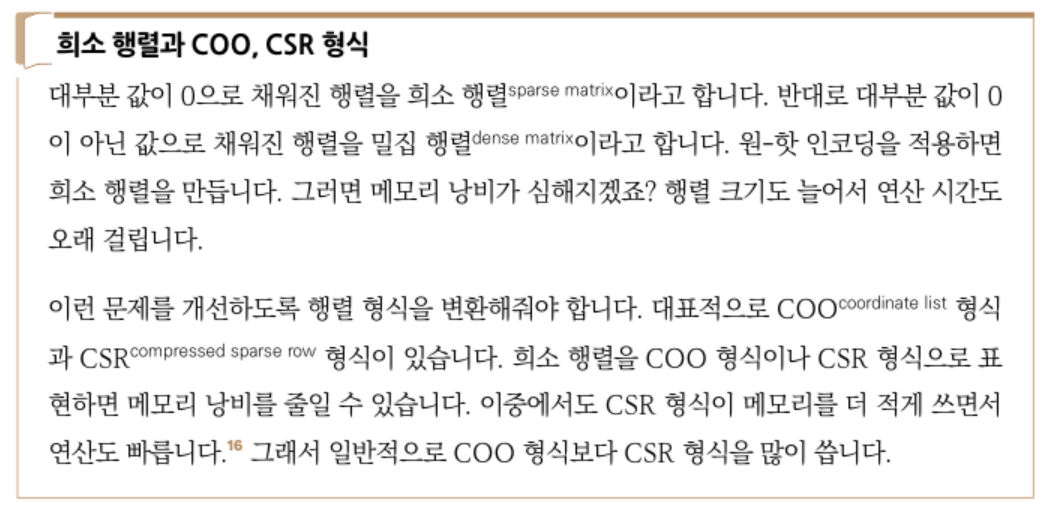

In [106]:
# 기존 명목형 피처 삭제
all_data = all_data.drop(nom_features, axis = 1)

In [107]:
all_data

,bin_0,bin_1,bin_2,bin_3,bin_4,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
id,,,,,,,,,,,,,
0,0,0,0,1,NaN,2,4,1,7.0,3.0,136.0,2,2
1,0,1,0,1,NaN,1,4,3,0.0,0.0,93.0,7,8
2,0,0,0,0,NaN,1,2,5,7.0,17.0,31.0,7,2
3,0,1,0,0,NaN,1,4,4,8.0,3.0,134.0,2,1
4,0,0,0,0,NaN,1,4,0,0.0,17.0,158.0,7,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,0,0,0,0,NaN,1,0,5,9.0,0.0,25.0,1,3
499996,1,0,0,0,NaN,1,1,5,5.0,18.0,17.0,2,2
499997,0,1,1,1,NaN,1,0,4,6.0,21.0,66.0,3,1


날짜 피처 인코딩

In [108]:
date_features = ['day', 'month']

encoded_date_matrix = onehot_encoder.fit_transform(all_data[date_features])

all_data = all_data.drop(date_features, axis= 1)

In [109]:
encoded_date_matrix

<500000x19 sparse matrix of type '<class 'numpy.float64'>'
	with 1000000 stored elements in Compressed Sparse Row format>

#### 피처 엔지니어링 2 : 피처 스케일링

ordinal feature 도 0~1사이의 값을 가지도록 스케일링

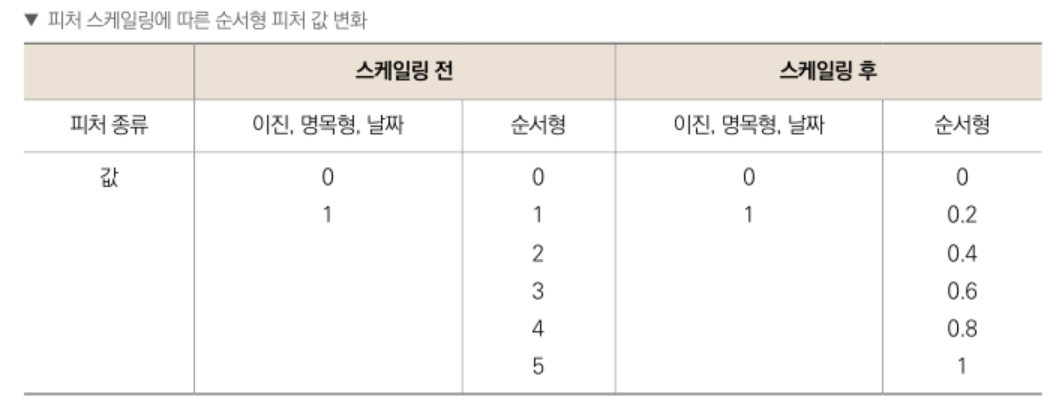

In [82]:
from sklearn.preprocessing import MinMaxScaler

In [110]:
ord_features = ['ord_' + str(i) for i in range(6)]

all_data[ord_features] = MinMaxScaler().fit_transform(all_data[ord_features])

In [111]:
all_data

,bin_0,bin_1,bin_2,bin_3,bin_4,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5
id,,,,,,,,,,,
0,0,0,0,1,NaN,0.5,1.00,0.2,0.500000,0.12,0.712042
1,0,1,0,1,NaN,0.0,1.00,0.6,0.000000,0.00,0.486911
2,0,0,0,0,NaN,0.0,0.50,1.0,0.500000,0.68,0.162304
3,0,1,0,0,NaN,0.0,1.00,0.8,0.571429,0.12,0.701571
4,0,0,0,0,NaN,0.0,1.00,0.0,0.000000,0.68,0.827225
...,...,...,...,...,...,...,...,...,...,...,...
499995,0,0,0,0,NaN,0.0,0.00,1.0,0.642857,0.00,0.130890
499996,1,0,0,0,NaN,0.0,0.25,1.0,0.357143,0.72,0.089005
499997,0,1,1,1,NaN,0.0,0.00,0.8,0.428571,0.84,0.345550


인코딩 및 스케일링 된 피처 합치기

all_data는 데이터 프레임이고, encoded_date_matrix, encoded_nom_matrix는 CSR 형식이다.  

csr_matrix로 all_data를 CSR 형식으로 맞추어 합친다.

In [86]:
from scipy import sparse

In [112]:
all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data), encoded_nom_matrix, encoded_date_matrix],
                             format = 'csr')

In [113]:
all_data_sprs

<500000x16306 sparse matrix of type '<class 'numpy.float64'>'
	with 9344078 stored elements in Compressed Sparse Row format>

- 피처수가 많다. 이정도 크기를 DataFrame으로 처리하면 메모리 낭비가 심하고 속도가 떨어진다.  
- 따라서 df로 변환하지 않고 CSR 형식을 그대로 사용한다.

데이터 나누기

In [114]:
num_train = len(train)

X_train = all_data_sprs[: num_train]
X_test = all_data_sprs[num_train:]

y = train['target']

In [115]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y,
                                                      test_size=0.1,
                                                      stratify=y,
                                                      random_state=10)

하이퍼 파라미터 최적화

In [116]:
%%time

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# 로지스틱 회귀 모델 생성
logistic_model = LogisticRegression()

# 하이퍼파라미터 값 목록
lr_params = {'C':[0.1, 0.125, 0.2], 'max_iter':[800, 900, 1000], 
             'solver':['liblinear'], 'random_state':[42]}

# 그리드서치 객체 생성
gridsearch_logistic_model = GridSearchCV(estimator=logistic_model,
                                         param_grid=lr_params,
                                         scoring='roc_auc', # 평가지표
                                         cv=5)
# 그리드서치 수행
gridsearch_logistic_model.fit(X_train, y_train)

print('최적 하이퍼파라미터:', gridsearch_logistic_model.best_params_)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

- 안됨....